In [1]:
import numpy as np
from basicpy import BaSiC
from scipy.ndimage import zoom
import zarr
from numcodecs import GZip 

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def transform(images, f, d=None):
    if d is not None:
        images_transformed = (images-d[np.newaxis])/f[np.newaxis]
    else:
        images_transformed = images/f[np.newaxis]
        
    return images_transformed


In [3]:
# path = '/u/home/f/f7xiesnm/project-zipursky/data/hold/sparse06/r1_export.n5'
path = "/u/scratch/f/f7xiesnm/sparse06/dataset.n5"
outpath = "/u/home/f/f7xiesnm/project-zipursky/data/hold/sparse06/r1_test_flatfield.n5"
zarr_data = zarr.open(store=zarr.N5Store(path), mode='r')

In [4]:
tileshape  = zarr_data[f'/setup13/timepoint0/s4'].shape
tileshape0 = zarr_data[f'/setup13/timepoint0/s1'].shape
print(tileshape, tileshape0)

(354, 120, 120) (2837, 960, 960)


In [5]:
images = zarr_data[f'/setup13/timepoint0/s4'][...]
images.shape

(354, 120, 120)

In [6]:
%%time
basic = BaSiC(get_darkfield=False, smoothness_flatfield=1)
basic.fit(images)

CPU times: user 45.3 s, sys: 6.65 s, total: 51.9 s
Wall time: 22.6 s


In [10]:
images_s1  = zarr_data[f'/setup13/timepoint0/s1'][1000:1200,:,:]
attributes = zarr_data[f'/setup13/timepoint0/s1'].attrs.asdict()
attributes['pixelResolution'] = [0.23, 0.23, 0.42] # useful later
attributes

{'downsamplingFactors': [2, 2, 1], 'pixelResolution': [0.23, 0.23, 0.42]}

In [11]:
ff_s4 = basic.flatfield
ff_s1 = zoom(basic.flatfield, 8)
images_transformed    = transform(images   , ff_s4).astype(np.uint16)
images_transformed_s1 = transform(images_s1, ff_s1).astype(np.uint16)

In [13]:
a0 = images_s1
a  = images_transformed_s1
a.dtype, a0.dtype

(dtype('uint16'), dtype('uint16'))

In [14]:
n5_root = zarr.open_group(store=zarr.N5Store(outpath), mode='w')
dataset = n5_root.require_dataset(
    'c0/s1',
    shape=a.shape,
    chunks=(128, 128, 128),
    dtype=a.dtype,
    compressor=GZip(level=1),
    data=a)
# set additional attributes
dataset.attrs.update(**attributes)

In [15]:
dataset0 = n5_root.require_dataset(
    'c00/s1',
    shape=a0.shape,
    chunks=(128, 128, 128),
    dtype=a0.dtype,
    compressor=GZip(level=1),
    data=a0)
# set additional attributes
dataset0.attrs.update(**attributes)

In [16]:
n5_root['c0/s1']

<zarr.core.Array '/c0/s1' (200, 960, 960) uint16>

In [17]:
n5_root['c00/s1']

<zarr.core.Array '/c00/s1' (200, 960, 960) uint16>

In [18]:
!ls $outpath
!cat $outpath/attributes.json
!cat $outpath/c0/s1/attributes.json

attributes.json  c0  c00
{
    "n5": "2.0.0"
}{
    "blockSize": [
        128,
        128,
        128
    ],
    "compression": {
        "level": 1,
        "type": "gzip",
        "useZlib": false
    },
    "dataType": "uint16",
    "dimensions": [
        960,
        960,
        200
    ],
    "downsamplingFactors": [
        2,
        2,
        1
    ],
    "pixelResolution": [
        0.23,
        0.23,
        0.42
    ]
}

In [19]:
!ls $outpath
!cat $outpath/attributes.json
!cat $outpath/c00/s1/attributes.json

attributes.json  c0  c00
{
    "n5": "2.0.0"
}{
    "blockSize": [
        128,
        128,
        128
    ],
    "compression": {
        "level": 1,
        "type": "gzip",
        "useZlib": false
    },
    "dataType": "uint16",
    "dimensions": [
        960,
        960,
        200
    ],
    "downsamplingFactors": [
        2,
        2,
        1
    ],
    "pixelResolution": [
        0.23,
        0.23,
        0.42
    ]
}

In [14]:
# get adata attributes correct

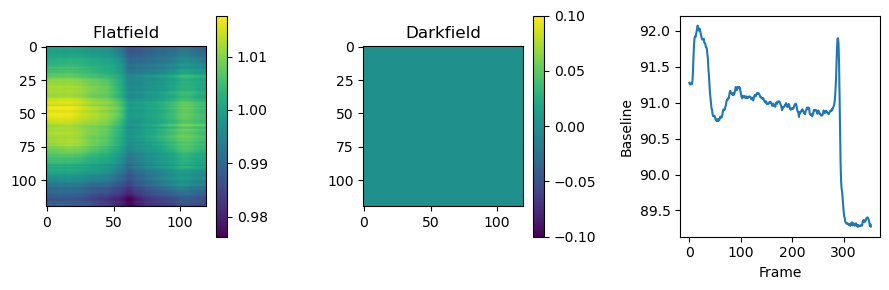

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
im = axes[0].imshow(basic.flatfield)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Flatfield")
im = axes[1].imshow(basic.darkfield)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Darkfield")
axes[2].plot(basic.baseline)
axes[2].set_xlabel("Frame")
axes[2].set_ylabel("Baseline")
fig.tight_layout()

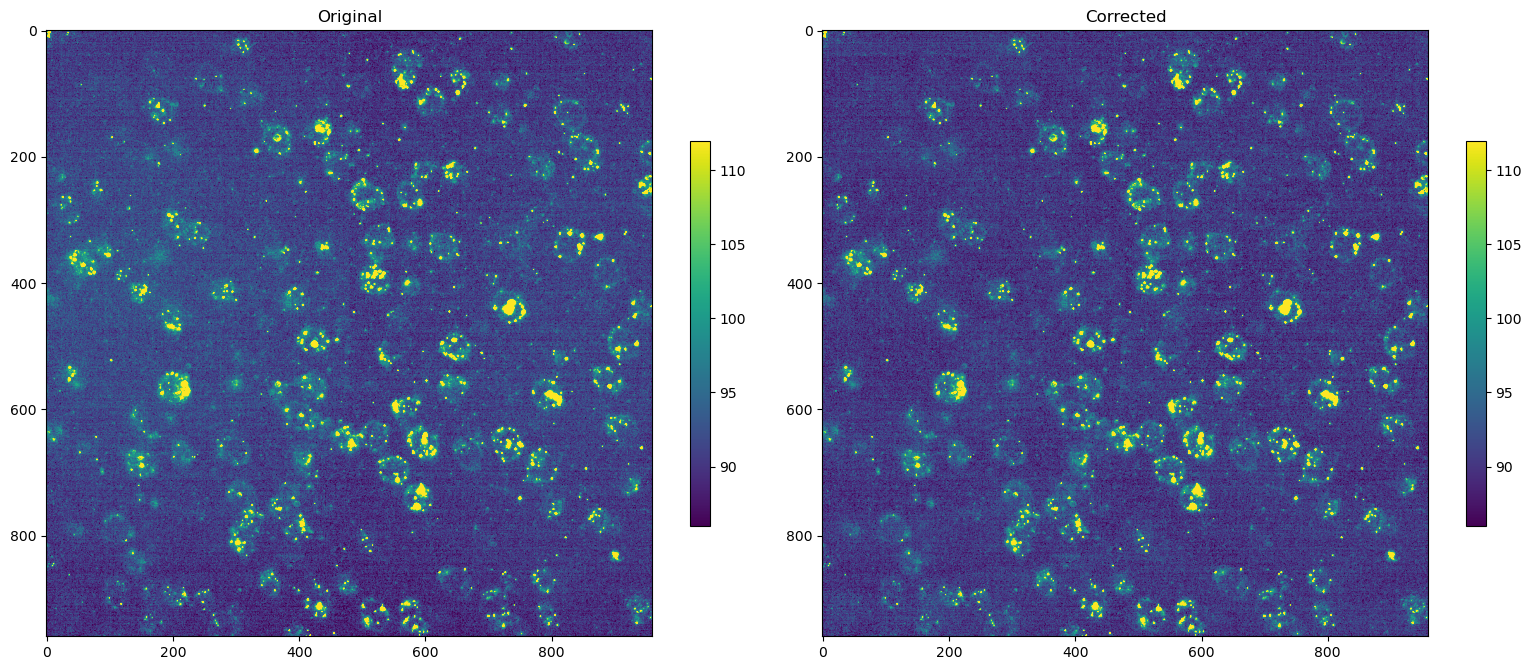

In [16]:
i = 100

vmin = np.percentile(images_transformed_s1[i], 5)
vmax = np.percentile(images_transformed_s1[i], 99)

fig, axes = plt.subplots(1, 2, figsize=(16,8))
im = axes[0].imshow(images_s1[i], vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[0], shrink=0.5)
axes[0].set_title("Original")
im = axes[1].imshow(images_transformed_s1[i], vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[1], shrink=0.5)
axes[1].set_title("Corrected")
fig.tight_layout()

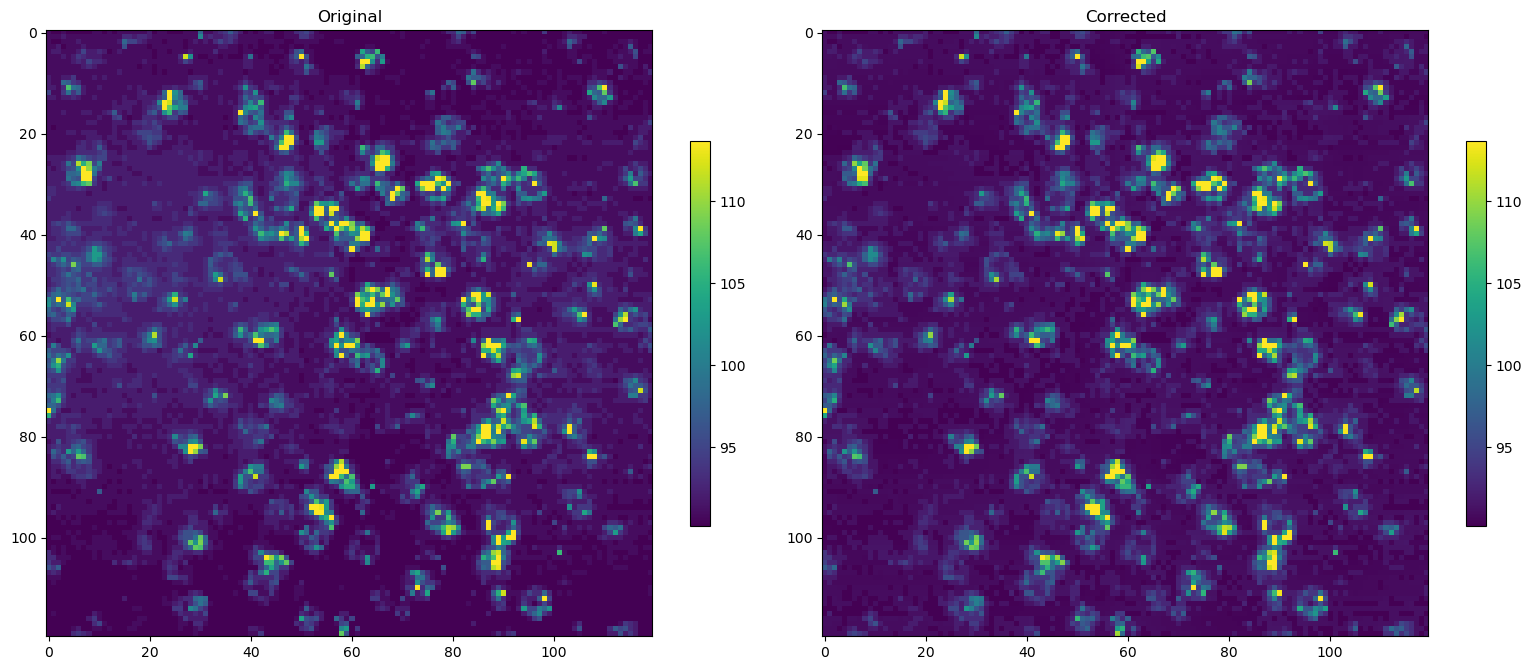

In [17]:
i = 100

vmin = np.percentile(images_transformed[i], 5)
vmax = np.percentile(images_transformed[i], 99)

fig, axes = plt.subplots(1, 2, figsize=(16,8))
im = axes[0].imshow(images[i], vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[0], shrink=0.5)
axes[0].set_title("Original")
im = axes[1].imshow(images_transformed[i], vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[1], shrink=0.5)
axes[1].set_title("Corrected")
fig.tight_layout()

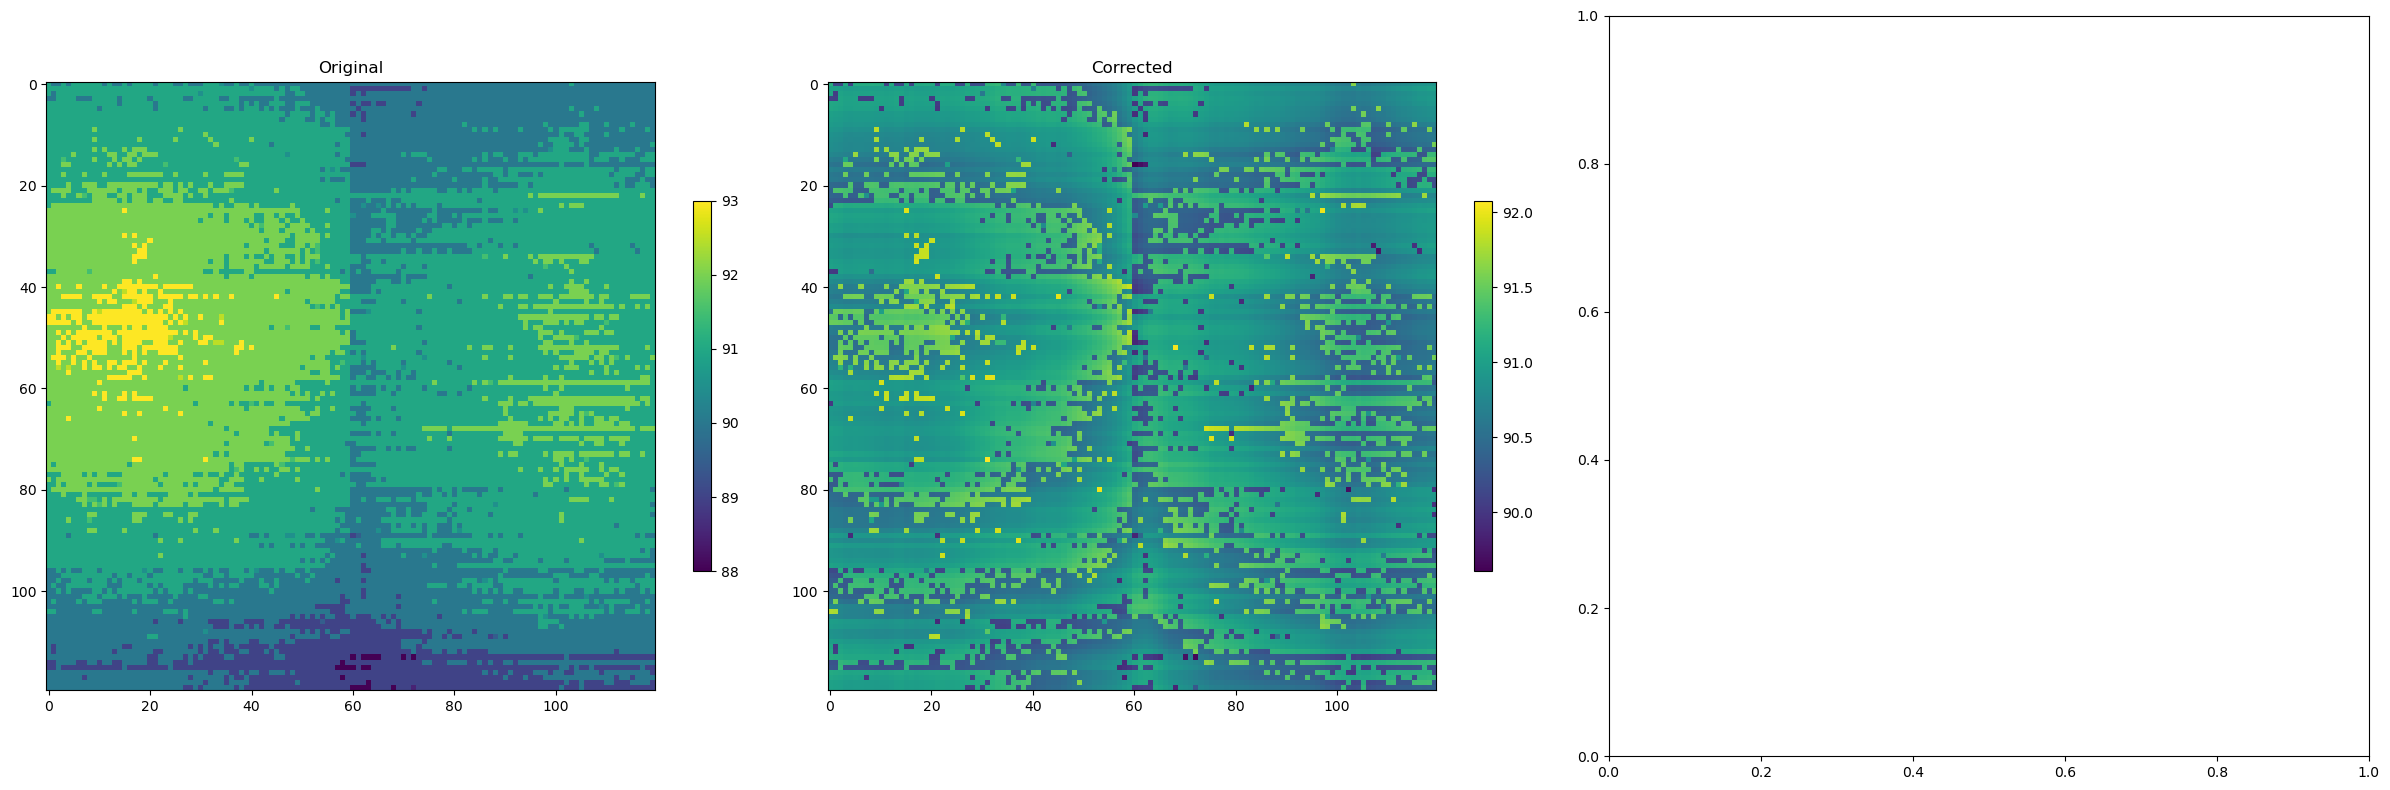

In [18]:
i = 50

vmin = np.percentile(images_transformed, 5)
vmax = np.percentile(images_transformed, 99)

fig, axes = plt.subplots(1, 3, figsize=(8*3,8))
im = axes[0].imshow(np.median(images, axis=0)) #, vmin=90, vmax=94)#, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[0], shrink=0.5)
axes[0].set_title("Original")
im = axes[1].imshow(np.median(images_transformed, axis=0)) # , vmin=90, vmax=94) #, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[1], shrink=0.5)
axes[1].set_title("Corrected")

# im = axes[2].imshow(np.median(images_transformed-images, axis=0)) # -np.max(images, axis=0))
# fig.colorbar(im, ax=axes[2], shrink=0.5)
# axes[2].set_title("Diff")
fig.tight_layout()

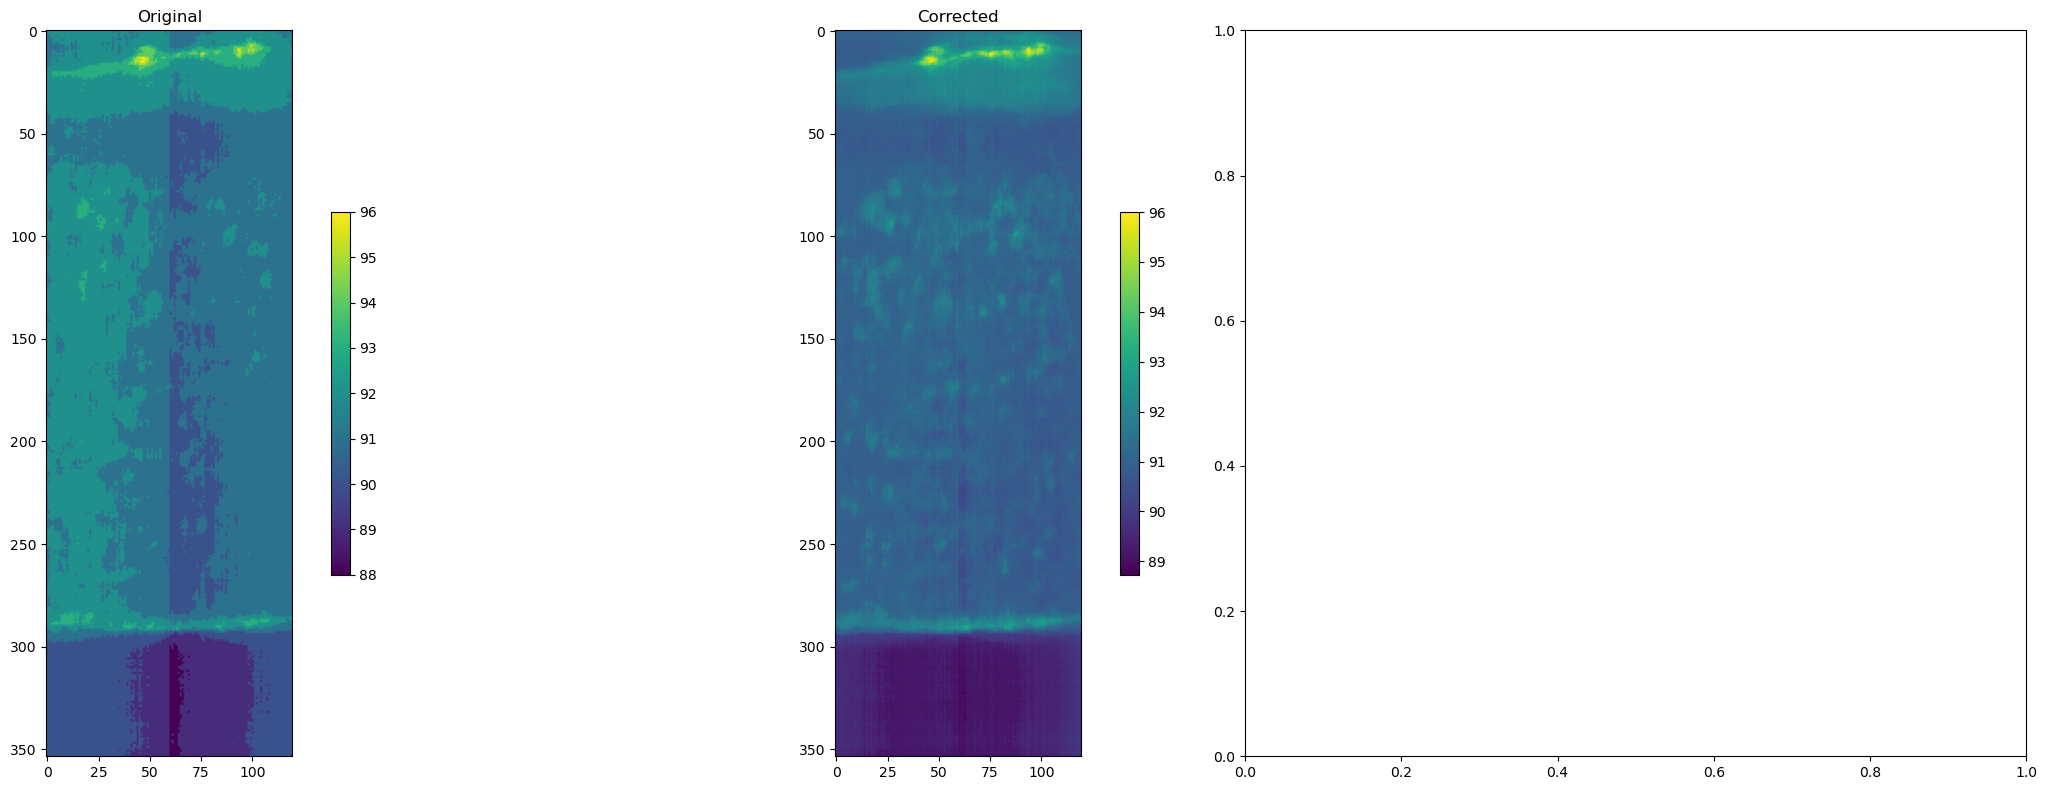

In [19]:

vmin = np.percentile(images_transformed, 5)
vmax = np.percentile(images_transformed, 99)

fig, axes = plt.subplots(1, 3, figsize=(8*3,8))
im = axes[0].imshow(np.median(images, axis=1)) #, vmin=90, vmax=95)#, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[0], shrink=0.5)
axes[0].set_title("Original")
im = axes[1].imshow(np.median(images_transformed, axis=1)) # , vmin=90, vmax=95) #, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[1], shrink=0.5)
axes[1].set_title("Corrected")

# im = axes[2].imshow(np.median(images_transformed-images, axis=1)) # -np.max(images, axis=0))
# fig.colorbar(im, ax=axes[2], shrink=0.5)
# axes[2].set_title("Diff")
fig.tight_layout()

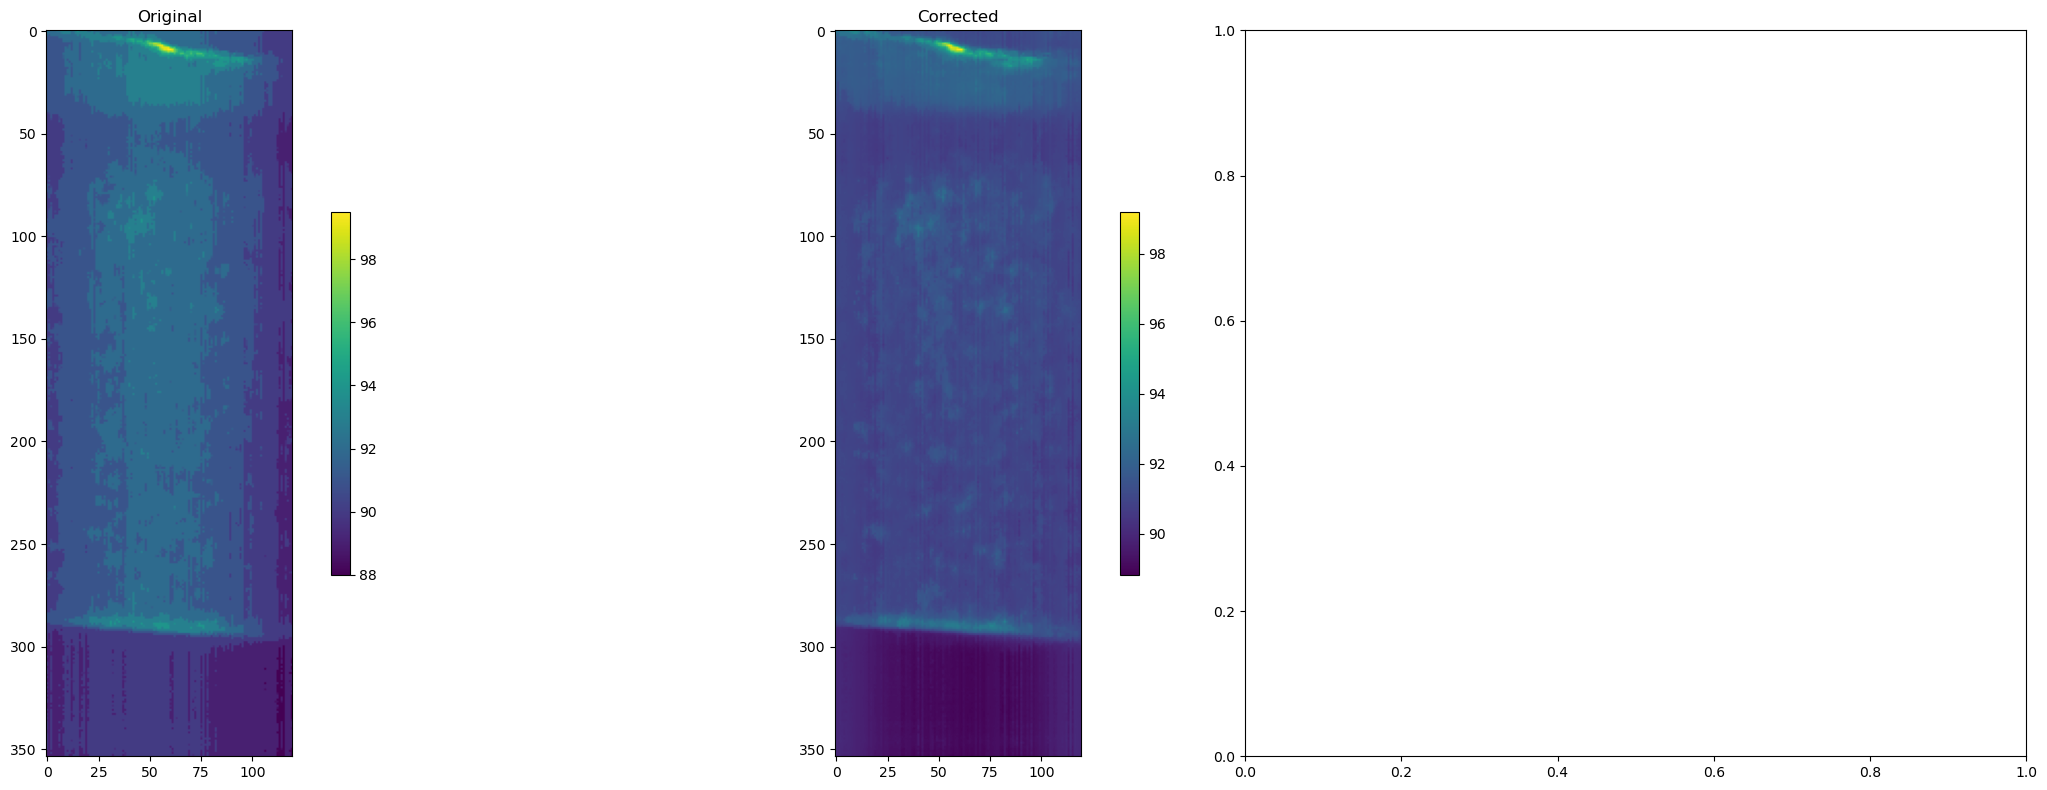

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(8*3,8))
im = axes[0].imshow(np.median(images, axis=2)) #, vmin=90, vmax=95)#, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[0], shrink=0.5)
axes[0].set_title("Original")
im = axes[1].imshow(np.median(images_transformed, axis=2)) # , vmin=90, vmax=95) #, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[1], shrink=0.5)
axes[1].set_title("Corrected")

# im = axes[2].imshow(np.median(images_transformed-images, axis=1)) # -np.max(images, axis=0))
# fig.colorbar(im, ax=axes[2], shrink=0.5)
# axes[2].set_title("Diff")
fig.tight_layout()

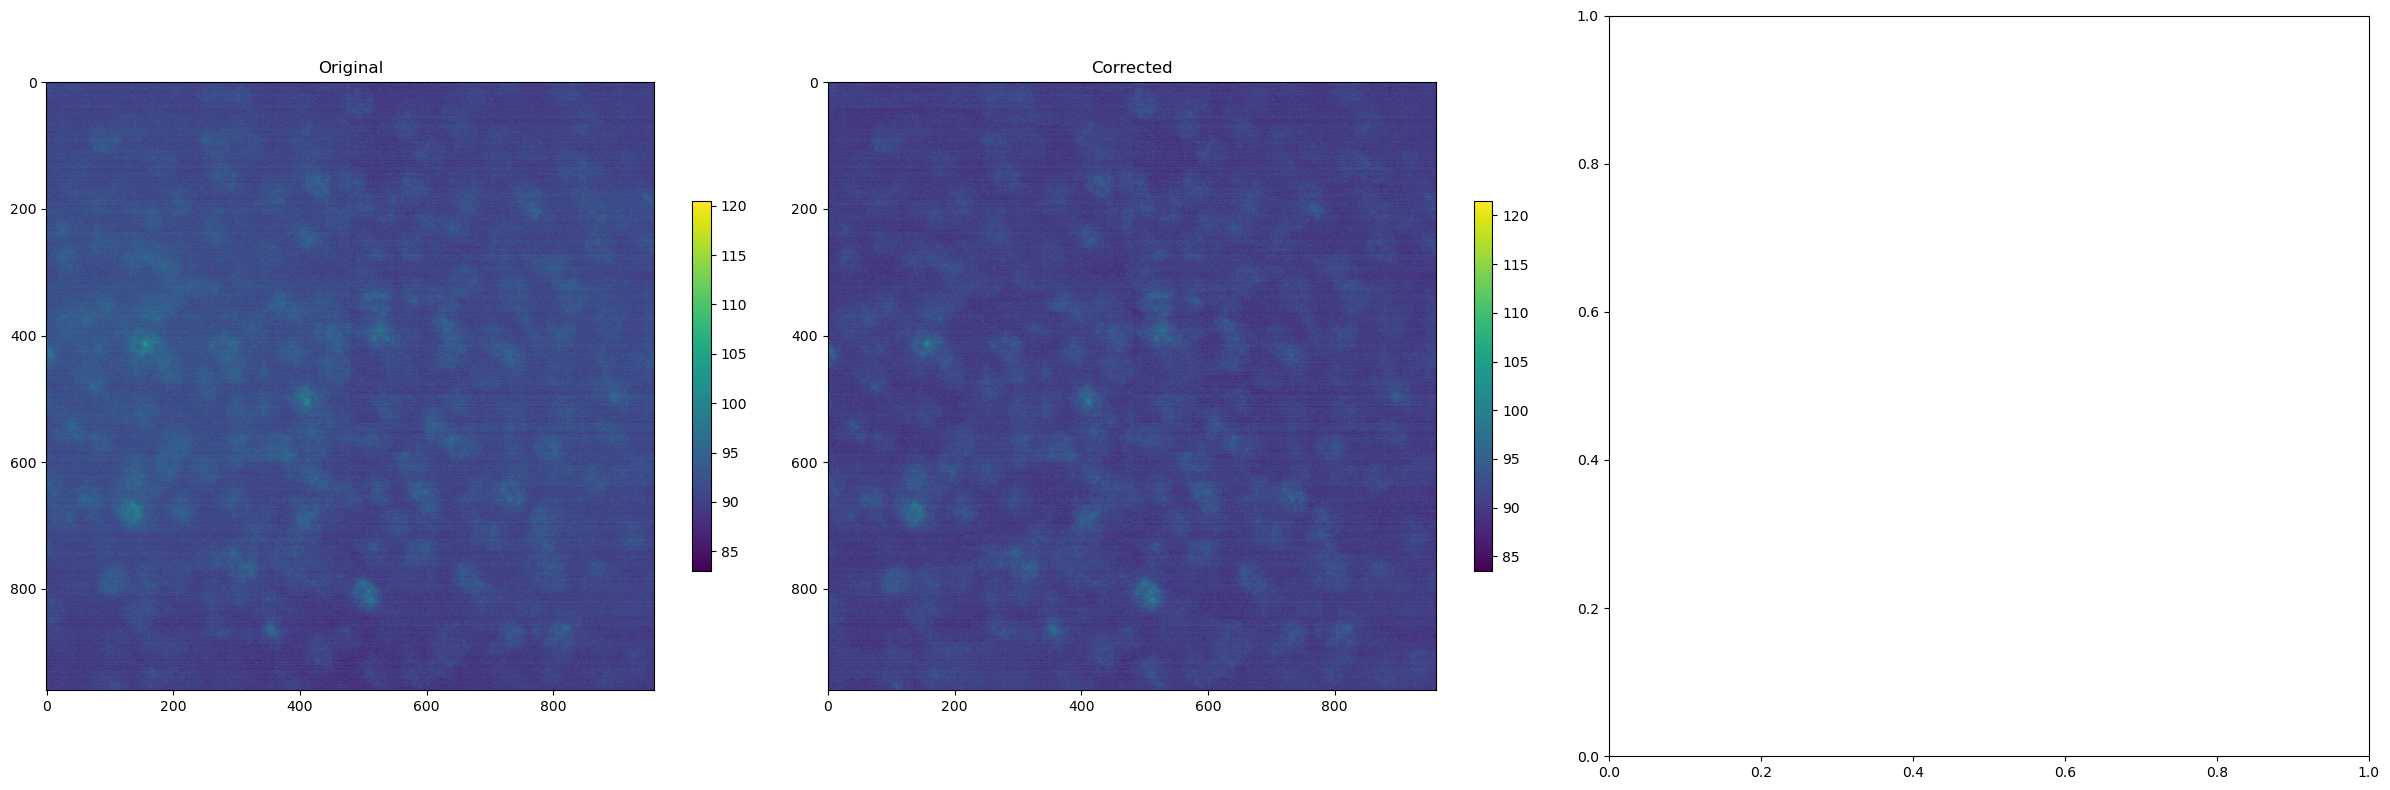

In [21]:
i = 50

vmin = np.percentile(images_transformed_s1, 5)
vmax = np.percentile(images_transformed_s1, 99)

fig, axes = plt.subplots(1, 3, figsize=(8*3,8))
im = axes[0].imshow(np.median(images_s1, axis=0)) #, vmin=90, vmax=94)#, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[0], shrink=0.5)
axes[0].set_title("Original")
im = axes[1].imshow(np.median(images_transformed_s1, axis=0)) # , vmin=90, vmax=94) #, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[1], shrink=0.5)
axes[1].set_title("Corrected")

# im = axes[2].imshow(np.median(images_transformed-images, axis=0)) # -np.max(images, axis=0))
# fig.colorbar(im, ax=axes[2], shrink=0.5)
# axes[2].set_title("Diff")
fig.tight_layout()

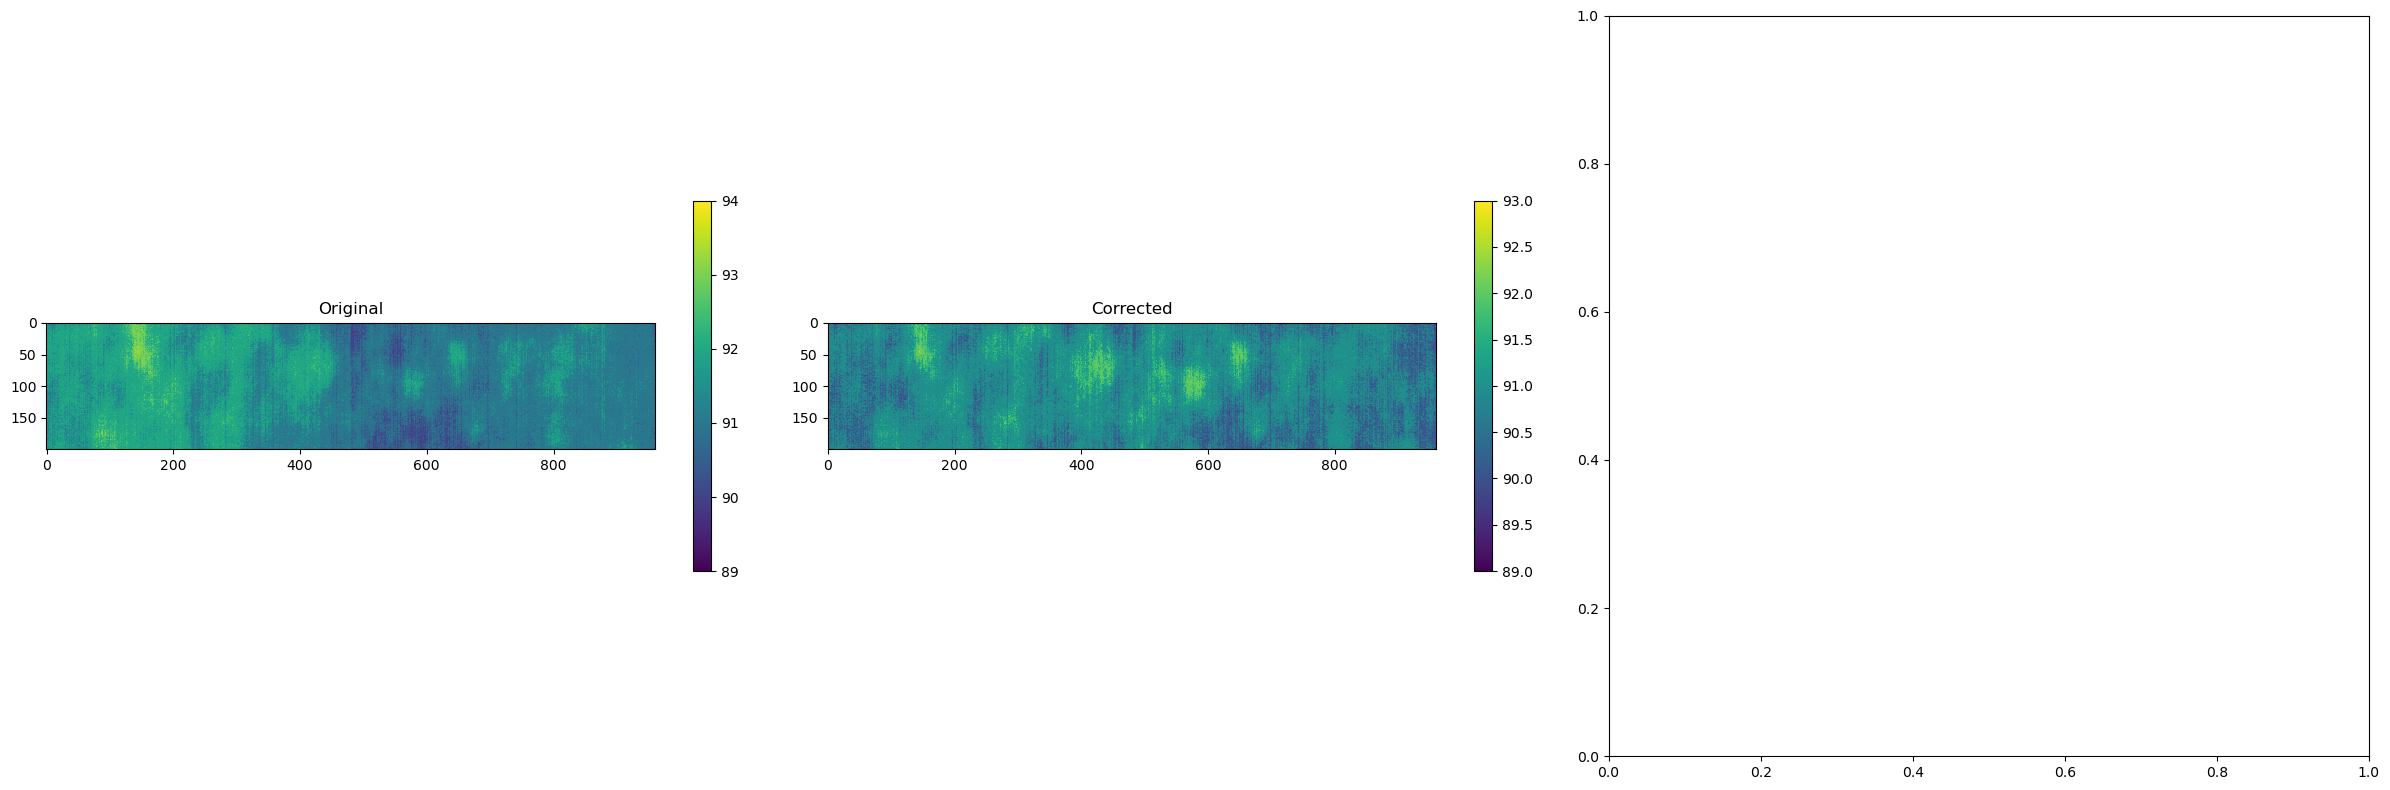

In [22]:

vmin = np.percentile(images_transformed_s1, 5)
vmax = np.percentile(images_transformed_s1, 99)

fig, axes = plt.subplots(1, 3, figsize=(8*3,8))
im = axes[0].imshow(np.median(images_s1, axis=1)) #, vmin=90, vmax=95)#, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[0], shrink=0.5)
axes[0].set_title("Original")
im = axes[1].imshow(np.median(images_transformed_s1, axis=1)) # , vmin=90, vmax=95) #, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[1], shrink=0.5)
axes[1].set_title("Corrected")

# im = axes[2].imshow(np.median(images_transformed-images, axis=1)) # -np.max(images, axis=0))
# fig.colorbar(im, ax=axes[2], shrink=0.5)
# axes[2].set_title("Diff")
fig.tight_layout()

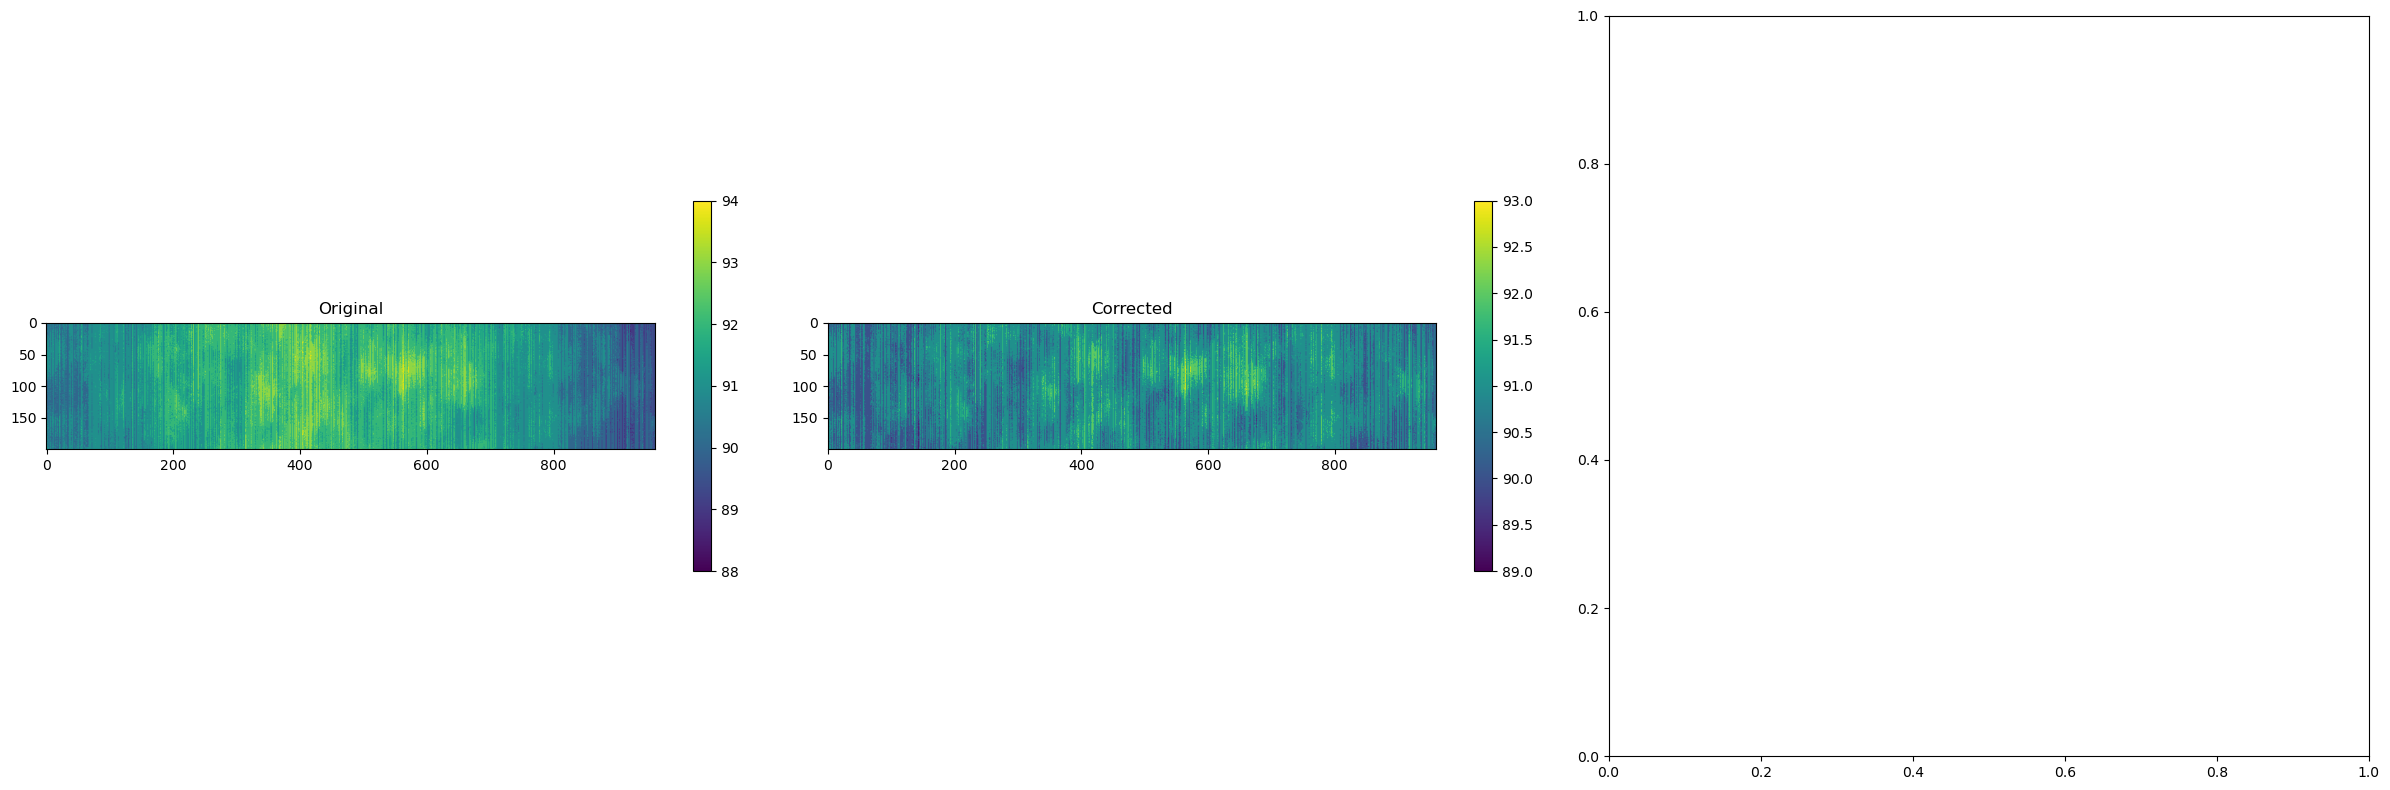

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(8*3,8))
im = axes[0].imshow(np.median(images_s1, axis=2)) #, vmin=90, vmax=95)#, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[0], shrink=0.5)
axes[0].set_title("Original")
im = axes[1].imshow(np.median(images_transformed_s1, axis=2)) # , vmin=90, vmax=95) #, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[1], shrink=0.5)
axes[1].set_title("Corrected")

# im = axes[2].imshow(np.median(images_transformed-images, axis=1)) # -np.max(images, axis=0))
# fig.colorbar(im, ax=axes[2], shrink=0.5)
# axes[2].set_title("Diff")
fig.tight_layout()